In [31]:
# Importing all the important libraries
import torch
import torch.nn as nn
from torch.nn import functional as F
# import mmap
# import random
# import pickle
# import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

# Setting all the hyperparamters
block_size = 8
batch_size = 4
max_iters = 50000
learning_rate = 3e-5
eval_iters = 5000
n_embd = 384
n_head = 4
n_layer = 6
dropout = 0.2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [32]:
# This is to read the text from the book
with open('pride_and_prejudice.txt', 'r', encoding = 'utf-8') as f:
    text = f.read()

# print(len(text))  # Length of the text
# print(text[:100]) # first 100 characters
chars = sorted(set(text))
vocab_size = len(chars)
print(chars)
print(len(chars))

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '1', '2', '3', '4', '5', '6', '8', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'ê']
77


In [33]:
# This is the code for the character-level tokenizer
string_to_int = { ch:i for i, ch in enumerate(chars)}
int_to_string = { i:ch for i, ch in enumerate(chars)}
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])

encoded_s = encode("hello")
decoded_s = decode(encoded_s)
print("\" " + str(decoded_s) + " \" : " + str(encoded_s))

" hello " : [56, 53, 60, 60, 63]


In [34]:
# Better to use a PyTorch Tensors
data = torch.tensor(encode(text), dtype = torch.long)
print(text[:100])
print()
print(data[:100])

PRIDE & PREJUDICE.

CHAPTER I.

It is a truth universally acknowledged, that a single man in possess

tensor([37, 38, 30, 25, 26,  1,  4,  1, 37, 38, 26, 31, 41, 25, 30, 24, 26, 11,
         0,  0, 24, 29, 22, 37, 40, 26, 38,  1, 30, 11,  0,  0, 30, 68,  1, 57,
        67,  1, 49,  1, 68, 66, 69, 68, 56,  1, 69, 62, 57, 70, 53, 66, 67, 49,
        60, 60, 73,  1, 49, 51, 59, 62, 63, 71, 60, 53, 52, 55, 53, 52,  9,  1,
        68, 56, 49, 68,  1, 49,  1, 67, 57, 62, 55, 60, 53,  1, 61, 49, 62,  1,
        57, 62,  1, 64, 63, 67, 67, 53, 67, 67])


In [35]:
# Dividing the dataset into train and validation
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

In [36]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)

    return x, y

In [37]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [38]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias = False)
        self.query = nn.Linear(n_embd, head_size, bias = False)
        self.value = nn.Linear(n_embd, head_size, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim = -1) # (B, T, T)
        wei = self.dropout(wei)

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

# [1, 0, 0]
# [1, 0.6, 0]
# [1, 0.6, 0.4]

In [39]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # (B, T, F) -> (B, T, [h1, h1, h1, h1, h2, h2, h2, h2, h3, h3, h3, h3])
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))
        return out

In [40]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [41]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x

In [42]:
class LargeLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)


        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean = 0.0, std = 0.02)

    def forward(self, index, targets=None):
        B, T = index.shape


        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(index) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        # index is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            index_cond = index[:, -block_size:]
            # get the predictions
            logits, loss = self.forward(index_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim = -1) # (B, C)
            # sample from the distribution
            index_next = torch.multinomial(probs, num_samples = 1) # (B, 1)
            # append sampled index to the running sequence
            index = torch.cat((index, index_next), dim = 1) # (B, T+1)
        return index

In [43]:
model = LargeLanguageModel(vocab_size)
# print('loading model parameters...')
# with open('model-01.pkl', 'rb') as f:
#     model = pickle.load(f)
# print('loaded successfully!')
m = model.to(device)

  0%|          | 5/50000 [01:39<205:46:54, 14.82s/it] 

Step: 0, Train loss: 4.427, Val loss: 4.434



 10%|█         | 5004/50000 [06:08<84:54:17,  6.79s/it] 

Step: 5000, Train loss: 2.067, Val loss: 2.065



 20%|██        | 10005/50000 [10:38<63:21:29,  5.70s/it]

Step: 10000, Train loss: 1.941, Val loss: 1.942



 30%|███       | 15005/50000 [15:07<54:48:30,  5.64s/it]

Step: 15000, Train loss: 1.870, Val loss: 1.871



 40%|████      | 20005/50000 [19:38<53:14:44,  6.39s/it]

Step: 20000, Train loss: 1.814, Val loss: 1.827



 50%|█████     | 25004/50000 [24:10<47:32:53,  6.85s/it]

Step: 25000, Train loss: 1.776, Val loss: 1.786



 60%|██████    | 30004/50000 [28:44<36:30:16,  6.57s/it]

Step: 30000, Train loss: 1.751, Val loss: 1.759



 70%|███████   | 35005/50000 [33:12<20:56:26,  5.03s/it]

Step: 35000, Train loss: 1.726, Val loss: 1.741



 80%|████████  | 40004/50000 [37:41<17:07:41,  6.17s/it]

Step: 40000, Train loss: 1.698, Val loss: 1.714



 90%|█████████ | 45004/50000 [42:12<8:27:49,  6.10s/it] 

Step: 45000, Train loss: 1.688, Val loss: 1.693



100%|██████████| 50000/50000 [45:06<00:00, 18.48it/s]


Final Loss: 1.6741677522659302



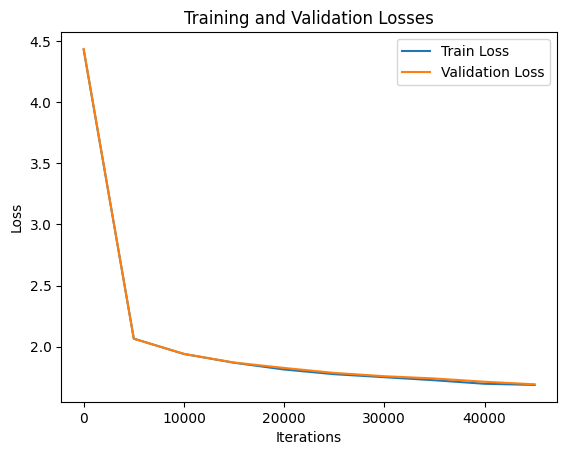

CPU times: user 44min 32s, sys: 11.4 s, total: 44min 43s
Wall time: 45min 6s


In [44]:
%%time
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

# Lists to store training and validation losses
train_losses = []
val_losses = []

for iter in tqdm(range(max_iters)):
    # print(iter)
    if iter % eval_iters == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        print(f"Step: {iter}, Train loss: {losses['train']:.3f}, Val loss: {losses['val']:.3f}")
        print()

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()

print("Final Loss: " + str(loss.item()) + "\n")

# Plotting the training and validation losses
plt.plot(range(0, max_iters, eval_iters), train_losses, label='Train Loss')
plt.plot(range(0, max_iters, eval_iters), val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [45]:
prompt = 'do you understand'
context = torch.tensor(encode(prompt), dtype = torch.long, device = device)
generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens = 500)[0].tolist())
print(generated_chars)

do you understand
finever earner could
notneft, her doin prefle to that has but he thine doubt any of that will strute recoomining.
You of his avorty, Mrs. Bennot recularessured bud--and, eached!----"Mise disceive beforderta had scend them. If in undiry to recollins, it how man the sayily repasions.

"The traoking him to us will gooking who Mr. Hertfuration of the not eour abmence, creosot to in any had count; you, but all to someton, and that the such which she
from Lydia xorwalked himselver."

"I crout ledt."

